##### 定义问题
- 有哪些数据可以用？
- 想要预测什么？
- 是否需要收集更多数据或雇人为数据手动添加标签

数据为新闻文本，并按照字符级别进行匿名处理。整合划分出14个候选分类类别：财经、彩票、房产、股票、家居、教育、科技、社会、时尚、时政、体育、星座、游戏、娱乐的文本数据。
赛题数据由以下几个部分构成：训练集20w条样本，测试集A包括5w条样本，测试集B包括5w条样本。为了预防选手人工标注测试集的情况，我们将比赛数据的文本按照字符级别进行了匿名处理。

In [1]:
import pandas as pd
# 若文件中存在utf-8不能解码的内容， 使用unicode_escape编码格式
df = pd.read_csv('data/train_set.csv', encoding='utf-8', sep='\t')

In [2]:
# 查看数据
print(df.columns)
print(df.head(3))

Index(['label', 'text'], dtype='object')
   label                                               text
0      2  2967 6758 339 2021 1854 3731 4109 3792 4149 15...
1     11  4464 486 6352 5619 2465 4802 1452 3137 5778 54...
2      3  7346 4068 5074 3747 5681 6093 1777 2226 7354 6...


In [2]:
# 统计每个句子的长度
# 把字符串转成整数列表
df['text_len'] = df['text'].apply(lambda x: len(x.split(' ')))
print(df['text_len'].describe())

count    200000.000000
mean        907.207110
std         996.029036
min           2.000000
25%         374.000000
50%         676.000000
75%        1131.000000
max       57921.000000
Name: text_len, dtype: float64


In [3]:
# 读取测试集
df_test = pd.read_csv('data/test_a.csv', encoding='utf-8', sep='\t')

In [8]:
#　查看测试集每条文本的长度信息
df_test['text_len'] = df_test['text'].apply(lambda x: len(x.split(' ')))
print(df_test['text_len'].describe())

count    50000.000000
mean       909.844960
std       1032.313375
min         14.000000
25%        370.000000
50%        676.000000
75%       1133.000000
max      41861.000000
Name: text_len, dtype: float64


原始数据有两列，第一列为标签，第二列为进行匿名处理的文本, 手动添加一列，记录每条文本的长度。一共有20万条文本，最大长度为57921，最短长度为2。每条记录的长度差异较大， 需要对较大的进行截断

In [5]:
# 查看新闻类别
print(df['label'].unique())
print(df.shape)

[ 2 11  3  9 10 12  0  7  4  1  6  5  8 13]
(200000, 3)


Text(0.5, 0, 'category')

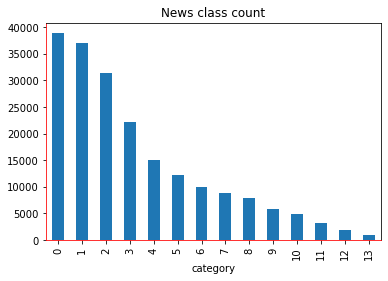

In [6]:
# 一共有14个类别，查看各个类别分布
import matplotlib.pyplot as plt
df['label'].value_counts().plot(kind='bar')
ax = plt.gca() # 获取当前的axes
ax.spines['left'].set_color('red')
ax.spines['bottom'].set_color('red')
plt.title('News class count')
plt.xlabel('category')

count    199995.000000
mean        907.229601
std         996.031330
min          11.000000
25%         374.000000
50%         676.000000
75%        1131.000000
max       57921.000000
Name: text_len, dtype: float64
(199995, 3)


Text(0.5, 0, 'category')

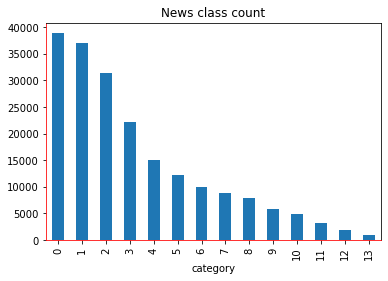

In [4]:
# 尝试删除长度过小的文本，测试集中长度最小的文本为14, 只有0.25的文本长度小于370
# 查看长度小于10的文本的类别分布情况
tmp = df.loc[df['text_len']>10]
print(tmp['text_len'].describe())
print(tmp.shape)
import matplotlib.pyplot as plt
tmp['label'].value_counts().plot(kind='bar')
ax = plt.gca() # 获取当前的axes
ax.spines['left'].set_color('red')
ax.spines['bottom'].set_color('red')
plt.title('News class count')
plt.xlabel('category')

各个类别分布严重不平衡, 且删除长度小于10的文本后，各类别分布基本不变

In [5]:
# 使用长度小于10的文本，作为训练集
df = tmp

In [9]:
# 统计每个字符出现的次数
# 执行时 kernel will restart
if False:
    from collections import Counter
    all_lines = ' '.join(list(df['text']))
    word_count = Counter(all_lines.split(" "))
    word_count = sorted(word_count.items(), key=lambda d:d[1], reverse=True)
    # 一共有多少个字
    print(len(word_count))
    # 出现次数最多的字的编号
    print(word_count[0])
    # 出现次数最少的字的编号
    print(word_count[-1])
# 根据不同字符在句子中出现的次数， 推测标点符号
# 根据推测的标点符号， 分析每篇新闻由多少个句子组成
# 分析每类新闻中 出现次数最多的字符

In [10]:
# 查看训练集中最大的字的编号
df['max'] = df['text'].apply(lambda x: max([int(num) for num in x.split()]))
df['max'].max()

7549

In [11]:
# 查看训练集中最小的字的编号
df['max'] = df['text'].apply(lambda x: min([int(num) for num in x.split()]))
df['max'].min()

0

## 数据分析的结论
1. 每个新闻平均字符个数较多，可能需要截断
2. 各个类别不均衡， 会严重影响模型的精度
3. 训练集中最大的编号为7549， 假设共有10000个不同的编号，即max_features=10000
4. 设置文本的长度为最大长度为300， maxlen=300
5. 最小编号为0， padding之前应对所有字符+1 或指定padding的value

##### 评估目标的方法
- 使用哪种指标对目标进行评估

本项目共存在14个类别， 且类别分布严重不平衡， 所以采用f1-score作为评估指标

##### 准备用于评估模型的验证过程。
- 定义训练集、验证集和测试集。验证集和测试集应该和训练集分开

In [6]:
# 定义训练集和验证集
from sklearn.model_selection import train_test_split

x_train = df['text'].values.tolist()
y_train = df['label'].values.tolist()
x_test = df_test['text'].values.tolist()

x_train, x_val, y_train, y_val = train_test_split(x_train,
                                                  y_train,
                                                  test_size=0.3,
                                                  random_state=1)

In [13]:
# 定义keras的数据生成器
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import sequence
import numpy as np

class DataGenerator(keras.utils.Sequence):
    def __init__(self, x, y, n_classes, maxlen=400, batch_size=32):
        '''Initialization'''
        self.x = x
        self.y = y
        self.n_classes = n_classes
        self.maxlen = maxlen
        self.batch_size = batch_size

    def __len__(self):
        ''' Denotes the number of batches per epoch'''
        # 必须进行整型转换
        return int(np.floor(len(self.y) / self.batch_size))
    
    def __data_process(self, inputs):
        '''Generate data containing batch_size samples'''
        X = []
        for x in inputs:
            # 将字符串转成整数的列表
            sentence = [int(num)+1 for num in x.split()]
            X.append(sentence)
        return X
    
    #一个batch的数据处理，返回需要feed到模型中训练的数据
    def __getitem__(self, index):
        '''Generate one batch of data'''
        # Generate indexes of the batch
        indexes = range(index*self.batch_size, (index+1)*self.batch_size)
        
        # Get inputs and labels from original data
        x = [self.x[index] for index in indexes]
        y = [self.y[index] for index in indexes]
        
        # Process inputs if needed
        x = self.__data_process(x)
        
        # padding
        x = sequence.pad_sequences(x, self.maxlen)
        
        # Transfer type to numpy.ndarray
        x = np.array(x)
        y = keras.utils.to_categorical(y, num_classes=self.n_classes)
        
        return x, y

In [14]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# 定义一个序列的最大长度
maxlen = 400
n_classes = 14
# 定义最大的字的编号（特征数）
max_features = 8000
batch_size = 1024
epochs = 10

train_generator = DataGenerator(x_train, y_train,
                                n_classes,
                                batch_size=batch_size,
                                maxlen=maxlen,
                               )
val_generator = DataGenerator(x_val, y_val,
                              n_classes,
                              batch_size=batch_size,
                              maxlen=maxlen,
                             )

##### 数据向量化（数据预处理）
- 将数据转换为能被神经网络接收的形式 

In [7]:
# 定义keras中计算f1-score的方法
# Copy from: https://www.fomalhaut.cn/370
import tensorflow as tf
from tensorflow import keras
import numpy as np

def create_f1():
    def f1_function(y_true, y_pred):
        y_pred_binary = tf.where(y_pred>=0.5, 1., 0.)
        # Avoid TypeError: Input 'y' of 'Mul' Op has type float32 that does not match type int32 of argument 'x'.
        tp = tf.reduce_sum(y_true * y_pred_binary)
        y_true = tf.cast(y_true, dtype=tf.float32)
        predicted_positives = tf.reduce_sum(y_pred_binary)
        possible_positives = tf.reduce_sum(y_true)
        return tp, predicted_positives, possible_positives
    return f1_function
class F1_score(keras.metrics.Metric):
    def __init__(self, **kwargs):
        super().__init__(**kwargs) # handles base args (e.g., dtype)
        self.f1_function = create_f1()
        self.tp_count = self.add_weight("tp_count", initializer="zeros")
        self.all_predicted_positives = self.add_weight('all_predicted_positives', initializer='zeros')
        self.all_possible_positives = self.add_weight('all_possible_positives', initializer='zeros')
    def update_state(self, y_true, y_pred, sample_weight=None):
        tp, predicted_positives, possible_positives = self.f1_function(y_true, y_pred)
        self.tp_count.assign_add(tp)
        self.all_predicted_positives.assign_add(predicted_positives)
        self.all_possible_positives.assign_add(possible_positives)
    def result(self):
        precision = self.tp_count / self.all_predicted_positives
        recall = self.tp_count / self.all_possible_positives
        f1 = 2*(precision*recall)/(precision+recall)
        return f1

# model.compile(loss='binary_crossentropy', optimizer= "adam", metrics=[F1_score()]) # NOTE： F1_score()
# 这种写法最大的优点在于，相当于在原来acc，loss的基础上添加了一个新的monitor即’val_f1_score’。
# checkpoint和earlystoping都可以使用这个参数来决定早停和保存模型, 测试集评估模型的时候，也能直接调用而不需要修改代码。例如：
'''
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint=ModelCheckpoint(filepath, monitor='val_f1_score', save_best_only=True, save_weights_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')
scores = model.evaluate(test_data, test_labels, verbose=0)
print('F1-score: ', scores[1])
'''

"\nfrom tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint\n\ncheckpoint=ModelCheckpoint(filepath, monitor='val_f1_score', save_best_only=True, save_weights_only=True, mode='max')\nearly_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')\nscores = model.evaluate(test_data, test_labels, verbose=0)\nprint('F1-score: ', scores[1])\n"

In [17]:
# 导入必须的包
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Embedding, SimpleRNN

# 定义一个简单的RNN模型
model = Sequential()
model.add(Embedding(max_features, 100))
model.add(SimpleRNN(32))
model.add(Dense(n_classes, activation='softmax'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=[F1_score()])

In [31]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor='val_f1_score',
        patience=2,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='SimpleRNN.h5',
        monitor='val_f1_score',
        save_best_only=True,
    )]

In [19]:
# 查看有效的CPU和GPU
import os
from tensorflow.python.client import device_lib
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "99"
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15192635899364302272
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14263522586555768966
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10630974656
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14737619137310654664
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 13903501323727520354
physical_device_desc: "device: XLA_GPU device"
]


In [15]:
# 指定使用GPU
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"             #选用GPU序号
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [32]:
# 拟合模型
history = model.fit(train_generator,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=val_generator,
                    validation_freq=1,
                    callbacks=callbacks_list,
                   )

Epoch 1/10
136/136 [==============================] - 43s 313ms/step - loss: 0.8963 - f1_score: 0.7274 - val_loss: 0.8408 - val_f1_score: 0.7446
Epoch 2/10
136/136 [==============================] - 42s 311ms/step - loss: 0.8512 - f1_score: 0.7405 - val_loss: 0.8948 - val_f1_score: 0.7379
Epoch 3/10
136/136 [==============================] - 42s 311ms/step - loss: 0.8511 - f1_score: 0.7422 - val_loss: 1.0059 - val_f1_score: 0.7184
Epoch 4/10
136/136 [==============================] - 43s 314ms/step - loss: 0.9191 - f1_score: 0.7209 - val_loss: 0.9104 - val_f1_score: 0.7175
Epoch 5/10
136/136 [==============================] - 42s 311ms/step - loss: 0.8330 - f1_score: 0.7505 - val_loss: 0.8522 - val_f1_score: 0.7486
Epoch 6/10
136/136 [==============================] - 43s 313ms/step - loss: 0.8103 - f1_score: 0.7571 - val_loss: 0.8494 - val_f1_score: 0.7444


##### 开发模型
- 使用fasttext模型作为基线模型， fasttext在划分的验证集上的f1score为0.8972
- 简单的RNN模型验证的f1-score为0.744远小于 fasttext，
- 尝试使用biLSTM模型

##### 调节超参数和正则化

In [16]:
# 使用一个biLSTM提取特征
# 导入必须的包
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Embedding, Bidirectional, LSTM

# 定义一个简单的双向RNN模型
class biLSTM():
    def __init__(self):
        pass
    
    def get_model(self):
        model = Sequential()
        model.add(Embedding(max_features, 100))
        # model.add(SimpleRNN(32))
        model.add(Bidirectional(LSTM(128)))
        model.add(Dense(n_classes, activation='softmax'))
        model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
                      metrics=[F1_score()])
        return model

In [20]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor='val_f1_score',
        patience=2,
        mode='max'
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='biLSTM.h5',
        monitor='val_f1_score',
        save_best_only=True,
    )]

history = model.fit(train_generator,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=val_generator,
                    validation_freq=1,
                    callbacks=callbacks_list,
                   )

Epoch 1/10
136/136 [==============================] - 47s 342ms/step - loss: 1.6386 - f1_score: 0.3955 - val_loss: 1.0554 - val_f1_score: 0.6480
Epoch 2/10
136/136 [==============================] - 47s 344ms/step - loss: 0.9364 - f1_score: 0.6972 - val_loss: 0.7270 - val_f1_score: 0.7739
Epoch 3/10
136/136 [==============================] - 46s 335ms/step - loss: 0.7294 - f1_score: 0.7754 - val_loss: 0.6977 - val_f1_score: 0.7820
Epoch 4/10
136/136 [==============================] - 45s 334ms/step - loss: 0.6443 - f1_score: 0.8049 - val_loss: 0.5548 - val_f1_score: 0.8367
Epoch 5/10
136/136 [==============================] - 46s 337ms/step - loss: 0.5809 - f1_score: 0.8286 - val_loss: 0.6085 - val_f1_score: 0.8244
Epoch 6/10
136/136 [==============================] - 46s 337ms/step - loss: 0.5600 - f1_score: 0.8345 - val_loss: 0.6959 - val_f1_score: 0.7860


双向LSTM模型在训练到第4轮时达到最佳f1-score： 0.8367，相比于简单的RNN有了较大的提升， 但仍远小于fasttext的效果。
从之前类别分布的信息中，我们知道， 样本的类别分布是非常不平衡的， 但是对于每个类别， 我们是同等对待的。 因此这里引入样本权重，来解决样本分布不均衡的问题。
在生成器中， 我们没有加入样本的权重， 下面可以尝试添加样本的权重再次训练该网络。为了避免将验证集的信息引入模型的训练过程， 在计算类别权重时，应该使用划分好的训练数据。
本问题中，各个类别之间应该是同等重要的，因此，不指定类别权重。

In [8]:
# 定义keras的附带权重信息的数据生成器
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import sequence
from sklearn.utils.class_weight import compute_sample_weight
import numpy as np

class DataGenerator(keras.utils.Sequence):
    def __init__(self, x, y=None, n_classes=None, maxlen=400, batch_size=32):
        '''Initialization'''
        self.x = x
        self.y = y
        self.n_classes = n_classes
        self.maxlen = maxlen
        self.batch_size = batch_size
        if self.y:
            self.sample_weights = compute_sample_weight("balanced", self.y)

    def __len__(self):
        ''' Denotes the number of batches per epoch'''
        # 必须进行整型转换
        return int(np.floor(len(self.x) / self.batch_size))
    
    def __data_process(self, inputs):
        '''Generate data containing batch_size samples'''
        X = []
        for x in inputs:
            # 将字符串转成整数的列表
            sentence = [int(num)+1 for num in x.split()]
            X.append(sentence)
        return X
    
    #一个batch的数据处理，返回需要feed到模型中训练的数据
    def __getitem__(self, index):
        '''Generate one batch of data'''
        # Generate indexes of the batch
        indexes = range(index*self.batch_size, (index+1)*self.batch_size)
        
        # Get inputs and labels from original data
        x = [self.x[index] for index in indexes]
        
        # Process inputs if needed
        x = self.__data_process(x)
        
        # padding
        x = sequence.pad_sequences(x, self.maxlen)
        
        # Transfer type to numpy.ndarray
        x = np.array(x)

        if self.y:
            y = [self.y[index] for index in indexes]
            sample_weights = [self.sample_weights[index] for index in indexes]
            y = keras.utils.to_categorical(y, num_classes=self.n_classes)
            sample_weights = np.array(sample_weights)
        
            return x, y, sample_weights
        return x

In [16]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# 定义一个序列的最大长度
maxlen = 400
n_classes = 14
# 定义最大的字的编号（特征数）
max_features = 8000
batch_size = 1024
epochs = 100
embedding_dims = 128

train_generator = DataGenerator(x_train, y_train,
                                n_classes,
                                batch_size=batch_size,
                                maxlen=maxlen,
                               )
val_generator = DataGenerator(x_val, y_val,
                              n_classes,
                              batch_size=batch_size,
                              maxlen=maxlen,
                             )

In [17]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor='val_f1_score_1',
        patience=2,
        mode='max'
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='biLSTM_sample_weights.h5',
        monitor='val_f1_score_1',
        save_best_only=True,
    )]

In [18]:
model = biLSTM().get_model()

NameError: name 'biLSTM' is not defined

In [39]:
history = model.fit(train_generator,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=val_generator,
                    validation_freq=1,
                    callbacks=callbacks_list,
                   )

Epoch 1/10
136/136 [==============================] - 47s 343ms/step - loss: 1.9784 - f1_score: 0.0907 - val_loss: 1.3752 - val_f1_score: 0.2964
Epoch 2/10
136/136 [==============================] - 47s 344ms/step - loss: 1.1171 - f1_score: 0.4765 - val_loss: 0.9579 - val_f1_score: 0.6224
Epoch 3/10
136/136 [==============================] - 47s 348ms/step - loss: 0.7824 - f1_score: 0.6923 - val_loss: 0.8791 - val_f1_score: 0.5191
Epoch 4/10
136/136 [==============================] - 47s 349ms/step - loss: 0.6701 - f1_score: 0.7436 - val_loss: 0.6427 - val_f1_score: 0.7707
Epoch 5/10
136/136 [==============================] - 47s 345ms/step - loss: 0.5835 - f1_score: 0.7892 - val_loss: 0.6056 - val_f1_score: 0.8107
Epoch 6/10
136/136 [==============================] - 46s 341ms/step - loss: 0.5343 - f1_score: 0.8081 - val_loss: 0.5781 - val_f1_score: 0.8394
Epoch 7/10
136/136 [==============================] - 46s 341ms/step - loss: 0.4980 - f1_score: 0.8199 - val_loss: 0.6101 - val_f1

引入样本权重后， 模型泛化效果并没有想象中的得到提升，f1-score仅有0.8394， 下面定义一个卷积网络进行训练

In [44]:
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.models import Sequential
class TextCNN():
    def __init__(self):
        pass
    
    def get_model(self):
        model = Sequential()
        model.add(Embedding(max_features, embedding_dims, input_length=maxlen))
        model.add(Conv1D(32, 7, activation='relu'))
        model.add(MaxPooling1D(5))
        model.add(Conv1D(32, 7, activation='relu'))
        model.add(GlobalMaxPooling1D())
        model.add(Dense(n_classes, activation='softmax'))
        return model

model = TextCNN().get_model()

In [45]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=[F1_score()])

In [ ]:
history = model.fit(train_generator,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=val_generator,
                    validation_freq=1,
                    callbacks=callbacks_list,
                   )

Epoch 8/10  
136/136 [==============================] - ETA: 0s - loss: 0.2736 - f1_score_1: 0.8938WARNING:tensorflow:Early   stopping conditioned on metric `val_f1_score` which is not available. Available metrics are:   loss,f1_score_1,val_loss,val_f1_score_1  
WARNING:tensorflow:Can save best model only with val_f1_score available, skipping.  
136/136 [==============================] - 43s 313ms/step - loss: 0.2736 - f1_score_1: 0.8938 - val_loss: 0.4793 - val_f1_score_1: 0.8729  
同一个notebook中第二次拟合模型时， monitor metrics 会由定义的val_f1_score变成val_f1_score_1  
TextCNN在训练到第8轮时达到最优， 然后开始过拟合， f1-score为0.8729， 相比biLSTM有了些许提升， 相比fasttext的0.89已非常接近。  
尝试结合RNN和CNN进行训练  

In [19]:
from tensorflow.keras import Input, Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Embedding, Dense, SimpleRNN, Lambda, Concatenate, Conv1D, GlobalMaxPooling1D


class TextRCNN(object):
    def __init__(self):
        pass

    def get_model(self):
        input_text = Input((maxlen,))

        embedder = Embedding(max_features, embedding_dims, input_length=maxlen)
        embedding = embedder(input_text)

        x_left = SimpleRNN(128, return_sequences=True)(embedding)
        x_right = SimpleRNN(128, return_sequences=True, go_backwards=True)(embedding)
        x_right = Lambda(lambda x: K.reverse(x, axes=1))(x_right)
        x = Concatenate(axis=2)([x_left, embedding, x_right])

        x = Conv1D(64, kernel_size=1, activation='tanh')(x)
        x = GlobalMaxPooling1D()(x)

        output = Dense(n_classes, activation='softmax')(x)
        model = Model(inputs=input_text, outputs=output)
        return model
    
textRCNN = TextRCNN().get_model()

In [20]:
textRCNN.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=[F1_score()])

In [21]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor='val_f1_score_1',
        patience=2,
        mode='max'
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='RCNN.h5',
        monitor='val_f1_score_1',
        save_best_only=True,
    )]

In [22]:
history = textRCNN.fit(train_generator,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=val_generator,
                    validation_freq=1,
                    callbacks=callbacks_list,
                   )

Epoch 1/100
136/136 [==============================] - 64s 474ms/step - loss: 1.9876 - f1_score_1: 0.1239 - val_loss: 1.1239 - val_f1_score_1: 0.5058
Epoch 2/100
136/136 [==============================] - 64s 471ms/step - loss: 0.7806 - f1_score_1: 0.7100 - val_loss: 0.5565 - val_f1_score_1: 0.8279
Epoch 3/100
136/136 [==============================] - 64s 471ms/step - loss: 0.4472 - f1_score_1: 0.8436 - val_loss: 0.5350 - val_f1_score_1: 0.7872
Epoch 4/100
136/136 [==============================] - 64s 471ms/step - loss: 0.3385 - f1_score_1: 0.8786 - val_loss: 0.3753 - val_f1_score_1: 0.8804
Epoch 5/100
136/136 [==============================] - 64s 473ms/step - loss: 0.2721 - f1_score_1: 0.8979 - val_loss: 0.3480 - val_f1_score_1: 0.8918
Epoch 6/100
136/136 [==============================] - 64s 471ms/step - loss: 0.2223 - f1_score_1: 0.9108 - val_loss: 0.3445 - val_f1_score_1: 0.8892
Epoch 7/100
136/136 [==============================] - 64s 473ms/step - loss: 0.1833 - f1_score_1: 0

RCNN的f1-score最高达到了0.90, 超过了fastText, 使用该模型提交测试结果

In [32]:
test_text = df_test.text.values.tolist()
test_generator = DataGenerator(test_text,
                                batch_size=batch_size,
                                maxlen=maxlen,
                               )

In [33]:
result = textRCNN.predict(test_generator)

In [34]:
result = np.argmax(result, axis=1)
result = pd.DataFrame({'label': result})

In [38]:
result.to_csv('rcnn.csv', index=False)

In [35]:
sample = pd.read_csv('./data/test_a_sample_submit.csv')